<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Four: Neural networks </h2>	


In [ ]:
WORKING_DIR = '/content/drive/My Drive/computer_vision/'
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/My Drive/computer_vision"
except:
    pass

Mounted at /content/drive
/content/drive/My Drive/computer_vision


In [ ]:
%load_ext autoreload

%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import cv2
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.})

%config InlineBackend.figure_format = 'retina'

MINIBATCH_SIZE = 4

In [ ]:
classes = ['airplanes','bear','blimp','comet','crab','dog','dolphin','giraffe',
           'goat','gorilla','kangaroo','killer-whale','leopards','llama',
           'penguin','porcupine','teddy-bear','triceratops', 'unicorn', 'zebra']
print(len(classes))

20


In [ ]:
train_params = {
    "minibatch_size": MINIBATCH_SIZE,
    "log_interval": 100,
    "n_pretrain_epochs": 100,
    "n_epochs": 2,
    "num_classes": 20,
    "workers": 0,
    "model_name": 'vgg16',
    "pretrain_model_path": './results/pretrain_model.pth',
    "model_path": './results/model.pth',
}

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.RandomSizedCrop(224),
     normalize])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:841: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [ ]:
# pre-train a VGG-16 model on ImageNet
# follow the link to download ImageNet (ILSVRC 2012) first https://www.tensorflow.org/datasets/catalog/imagenet2012
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

pretrain_trainset = torchvision.datasets.ImageNet(root='./imagenet20', train=True, transform=transform)
pretrain_trainloader = torch.utils.data.DataLoader(pretrain_trainset, 
                                                   batch_size=train_params['minibatch_size'],
                                                   shuffle=True, 
                                                   num_workers=train_params['workers'])

pretrain_testset = torchvision.datasets.ImageNet(root='./imagenet20', train=False, transform=transform)
pretrain_testloader = torch.utils.data.DataLoader(pretrain_testset, 
                                                  batch_size=train_params['minibatch_size'],
                                                  shuffle=False,
                                                  num_workers=train_params['workers'])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def build_network():
    network = torchvision.models.vgg16(pretrained=False)
    network.classifier._modules['6'] = nn.Linear(4096, train_params["num_classes"])
    return network

network = build_network()
print(network)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
network.classifier._modules['6'] = nn.Linear(4096, 100)
pretrain_optimizer = optim.Adam(network.parameters())
for epoch in range(train_params['n_pretrain_epochs']):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(pretrain_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        pretrain_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        pretrain_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
torch.save(network.state_dict(), train_params['pretrain_model_path'])

In [ ]:
# Reference:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://pytorch.org/docs/stable/torchvision/models.html#classification
# https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101

dataset = datasets.ImageFolder('20_categories_training/20_categories_training', 
                               transforms.Compose([transforms.RandomSizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize]))
trainlen = int(len(dataset)*0.6)
vallen = int(len(dataset)*0.2)
testlen = len(dataset)-trainlen-vallen
trainset, valset, testset = torch.utils.data.random_split(dataset, [trainlen,vallen,testlen])

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=train_params['minibatch_size'], shuffle=True,
    num_workers=train_params['workers'], pin_memory=True)

valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=train_params['minibatch_size'], shuffle=True,
    num_workers=train_params['workers'], pin_memory=True)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=train_params['minibatch_size'], shuffle=True,
    num_workers=train_params['workers'], pin_memory=True)

print(len(trainloader), len(valloader), len(testloader))

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:841: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


225 75 76


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  unicorn leopards  goat giraffe


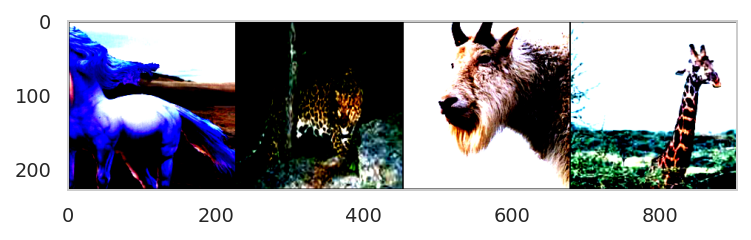

In [ ]:
def showimg(img, labels):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.grid(False)
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(MINIBATCH_SIZE)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

showimg(torchvision.utils.make_grid(images), labels)

For the neural network architecture we will use a similar architecture to VGG-16, except that we modify the number of output classes to 20:

![VGG-16 Architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

As activation function we will use rectified linear units (ReLU). For the loss function we will use classification appropriate Cross-Entropy Loss and Adam to find optimal parameters.

Cross Entropy Loss (given here for binary classification for simplicity)

$ R(\theta) \doteq - \frac{1}{n} \sum\limits_{i=1}^n \left ( y_i \log(\sigma(X_i^T \theta)) + (1 - y_i) \log(1 - \sigma(X_i^T \theta)) \right ) $



### Train the Network

In [ ]:
train_errors = []
train_counter = []
val_errors = []
val_counter = [i*len(trainloader.dataset) for i in range(train_params['n_epochs'])]

def train(epoch, log_interval, minibatch_size):
    """Defines the training procedure.
    
    - epoch: number of times to go over the entire dataset
    - log_interval: frequency to log losses and save the model states
    - minibatch_size: this is the number of batch size as selected in the DataLoader
    """
    
    network.train()
    
    for batch_idx, data in enumerate(trainloader, 0):
        # unpack data to get the inputs: data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # run network once before everything to see the starting loss on cold
        outputs = network(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward() # <- back prop
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] loss: {}'.format(epoch, 
                                                      batch_idx * len(inputs),
                                                      len(trainloader.dataset),
                                                      100*batch_idx / len(trainloader),
                                                      loss.item()))
            
            train_errors.append(loss.item())
            train_counter.append(
                (batch_idx * minibatch_size) + ((epoch-1)*len(trainloader.dataset)))
            
    print("Finished epoch {}".format(epoch))

def validate():
    """Defines the validation procedure
    
    """
    network.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():

        for data in valloader:
            images = data[0].to(device)
            labels = data[1].to(device)

            outputs = network(images.float())
            val_loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels.data.view_as(predicted)).sum()

    
    val_loss /= len(valloader)
    val_errors.append(val_loss)
    
    print("\nValidation Set: avg. loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n".format(val_loss, 
                                                                              correct, 
                                                                              len(valloader.dataset), 
                                                                              100.*correct / len(valloader.dataset)))

In [ ]:
network = build_network()
# network.load_state_dict(torch.load(train_params['pretrain_model_path']))
for param in network.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
network.classifier._modules['6'] = nn.Linear(4096, train_params["num_classes"])

# send the parameters to GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
network.to(device)

# define optimality criterian or the loss functiona
optimizer = optim.Adam(network.classifier._modules['6'].parameters())

for epoch in range(1, train_params['n_epochs'] + 1):
    train(epoch, train_params['log_interval'], train_params['minibatch_size'])
    print("Snapshotting model\n")
    torch.save(network.state_dict(), './results/model-{}-epoch{}.pth'.format(train_params['model_name'],epoch))
    torch.save(optimizer.state_dict(), './results/optimizer-{}-epoch{}.pth'.format(train_params['model_name'],epoch))
    validate()

cpu
Train Epoch: 1 [0/900 (0%)] loss: 3.0691099166870117
Train Epoch: 1 [400/900 (44%)] loss: 0.3545466959476471
Train Epoch: 1 [800/900 (89%)] loss: 1.5890207290649414
Finished epoch 1
Snapshotting model


Validation Set: avg. loss: 0.4366, accuracy: 258/300 (86%)

Train Epoch: 2 [0/900 (0%)] loss: 0.34687793254852295
Train Epoch: 2 [400/900 (44%)] loss: 0.17682532966136932
Train Epoch: 2 [800/900 (89%)] loss: 0.06531423330307007
Finished epoch 2
Snapshotting model


Validation Set: avg. loss: 0.5295, accuracy: 249/300 (83%)



The cross validation accuracy drops after the first epoch. So, we stop training and use the model trained after epoch 1.

Text(0, 0.5, 'Negative Log Likelihood Loss')

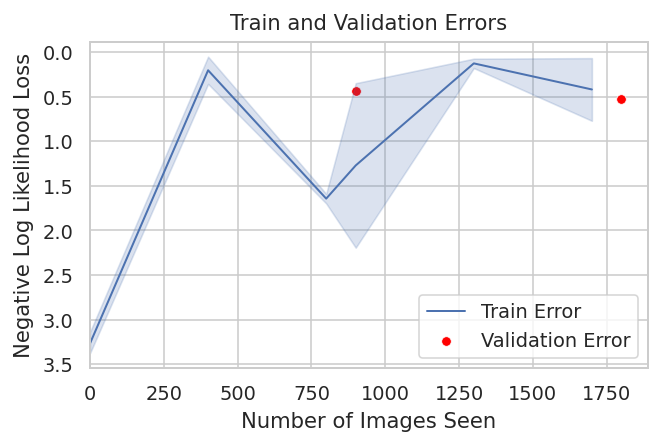

In [ ]:
fig = plt.figure(figsize=(5, 3))

sns.scatterplot(data=pd.DataFrame({"counter": val_counter, "errors": val_errors}), x='counter', y='errors', color='red', label='Validation Error')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')

ax = sns.lineplot(data=pd.DataFrame({"counter": train_counter, "errors": train_errors}), x='counter', y='errors', label='Train Error')
ax.set_xlim(0)
ax.set_title("Train and Validation Errors")
ax.set_xlabel("Number of Images Seen")
ax.set_ylabel("Negative Log Likelihood Loss")

#### Print the Final Model Accuracy on the Test Set

In [ ]:
# Load Model From Snapshot
network = build_network()
network.load_state_dict(torch.load(train_params['model_path']))

<All keys matched successfully>

In [ ]:
# Final model accuracy on the test set

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = network(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 301 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 301 test images: 83 %


In [ ]:
# Final model accuracy on each class
class_correct = [0.]*20
class_total = [0.]*20

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = network(images.float())
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(predicted.size()[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [ ]:
for i in range(20):
    print('Accuracy of %s : %.2f'%(classes[i], class_correct[i] / class_total[i]))

Accuracy of airplanes : 1.00
Accuracy of bear : 0.50
Accuracy of blimp : 0.67
Accuracy of comet : 0.95
Accuracy of crab : 1.00
Accuracy of dog : 0.70
Accuracy of dolphin : 0.69
Accuracy of giraffe : 0.73
Accuracy of goat : 0.82
Accuracy of gorilla : 0.93
Accuracy of kangaroo : 1.00
Accuracy of killer-whale : 0.88
Accuracy of leopards : 1.00
Accuracy of llama : 0.86
Accuracy of penguin : 0.92
Accuracy of porcupine : 1.00
Accuracy of teddy-bear : 0.75
Accuracy of triceratops : 0.87
Accuracy of unicorn : 0.62
Accuracy of zebra : 0.91


#### Test Model on A Single Batch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  gorilla comet gorilla penguin
Predicted:  gorilla comet gorilla penguin


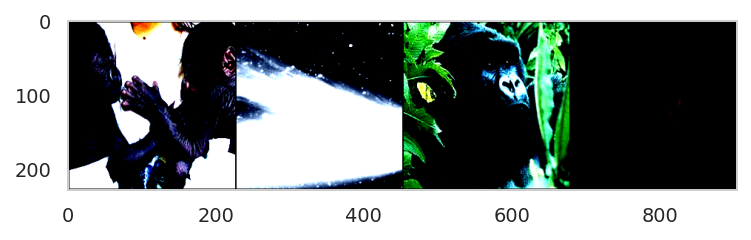

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print ZCA encoded Images
showimg(torchvision.utils.make_grid(images), labels)

# predict
with torch.no_grad():
    outputs = network(images.float())
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(MINIBATCH_SIZE)))


## Prediction

In [ ]:
X_train_tensor = torch.load('X_train_tensor.pt')
network = build_network()
network.load_state_dict(torch.load(train_params['model_path']))
unlabeled_data = pd.read_pickle('unlabeled_data.pkl')

In [ ]:
class DataframeDataset(torch.utils.data.Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.df.iloc[idx, 0]
        if self.transform:
            sample = self.transform(image)
        return sample

In [ ]:
unlabeledset = DataframeDataset(unlabeled_data, transform)
unlabeledloader = torch.utils.data.DataLoader(
    unlabeledset,
    batch_size=train_params['minibatch_size'], shuffle=False,
    num_workers=train_params['workers'], pin_memory=True)

In [ ]:
prediction = []
with torch.no_grad():
    for data in unlabeledloader:
        images = data
        outputs = network(images.float())
        _, predicted = torch.max(outputs, 1)
        prediction = prediction + predicted.tolist()
len(prediction)

716

In [ ]:
# Save labels
# pd.Dataframe(prediction).to_csv('nn_prediction.csv', index=False, header=False)

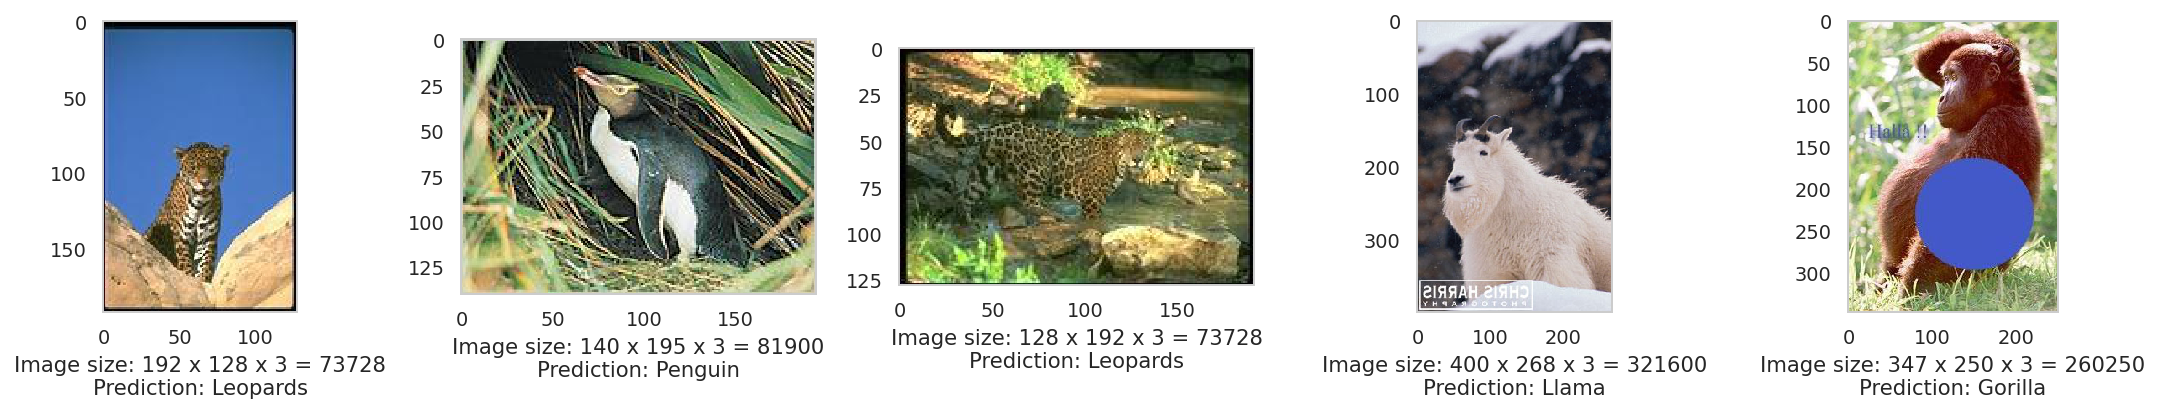

In [ ]:
import skimage
import skimage.io
class_names=['Airplanes', 'Bear', 'Blimp', 'Comet', 'Crab', 'Dog', 'Dolphin',
             'Giraffe', 'Goat', 'Gorilla', 'Kangaroo', 'Killer-Whale',
             'Leopards', 'Llama', 'Penguin', 'Porcupine', 'Teddy-Bear',
             'Triceratops', 'Unicorn', 'Zebra']# Visualize 5 random results
samples = unlabeled_data.sample(n=5)
plt.figure(figsize=(15,3))
for i in range(5):
    pic = samples.iloc[i,0]
    fig = plt.subplot(1,5,i+1)
    fig.grid(False)
    skimage.io.imshow(pic)
    fig.set_xlabel(f'Image size: {pic.shape[0]} x {pic.shape[1]} x ' +
    f'{pic.shape[2]} = {pic.size}\n'+
    f'Prediction: {class_names[prediction[samples.index[i]]]}')